## Setup

Load required packages

In [1]:
import pandas as pd
import io
import requests
import numpy as np
import random
import libpysal
import pysal
import pysal.lib

C:\ProgramData\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


Read data

In [2]:
#Read from URL (Doesnt work for private repos)
#url="https://github.com/konstantinklemmer/spacegan/raw/master/data/synth_data.csv"
#s=requests.get(url).content
#data=pd.read_csv(io.StringIO(s.decode('utf-8')))

#Read from local file
data_ex1 = pd.read_csv("C:/Users/Konstantin Klemmer/Documents/GitHub/spacegan/data/synth_data_ex1.csv")
data_ex2 = pd.read_csv("C:/Users/Konstantin Klemmer/Documents/GitHub/spacegan/data/synth_data_ex2.csv")

## Spatial Grid Expansion

This function takes in a regular point grid `data` (with coordinates `longitude` and `latitude`, input variable `z` and output variable `y`) and a factor `fact` by which the grid is to be expanded (e.g., `fact=2` doubles the grid cells (roughly))

In [3]:
def grid_expand_interpolate(data,fact):
    
    #Create lon and lat groups (for the case that the test data splits our regular box in two separate training sets)
    lon_unique = data.longitude.unique() #Get unique lon/lat values
    inp = np.insert(np.diff(data.longitude.unique()),0,np.min(np.diff(data.longitude.unique()))) #Get differences at each step
    res = []
    k = 1
    for i in inp: #Loop over differences and assign new group if a gap is detected
        if i != np.min(inp):
            k = k+1
        else:
            k = k
        res += [k]

    d = {'longitude': lon_unique, 'group_lon': res} #Bind into a dataframe
    lon_group = pd.DataFrame(data=d)
    #Repeat for latitude
    lat_unique = data.latitude.unique()
    inp = np.insert(np.diff(data.latitude.unique()),0,np.min(np.diff(data.latitude.unique())))
    res = []
    k = 1
    for i in inp:
        if i != np.min(inp):
            k = k+1
        else:
            k = k
        res += [k]
    d = {'latitude': lat_unique, 'group_lat': res}
    lat_group = pd.DataFrame(data=d)
    #Merge with input data
    data = pd.merge(lon_group,data, how="right", on=["longitude"])
    data = pd.merge(lat_group,data, how="right", on=["latitude"])
    #Create dataset for storing the final results
    final_data = pd.DataFrame()
    
    for o in data.group_lat.unique():
        #Select group
        temp1_data = data[data["group_lat"]==o]
        for p in temp1_data.group_lon.unique():
            #Select group
            temp_data = temp1_data[temp1_data["group_lon"]==p]
            #Create new grid:
            #Copy column names from existing grid
            new_points = pd.DataFrame(columns=temp_data[["longitude","latitude"]].columns)
            #Expand longitude by factor `fact`
            dst = (temp_data[["longitude"]].max() - temp_data[["longitude"]].min()) / (len(temp_data.longitude.unique())-1)
            exp = float(dst/fact)
            x = []
            d = float(temp_data[["longitude"]].min())
            while d <= float(temp_data[["longitude"]].max()):
                x.append(d)    
                d = d + exp
            #Expand latitude by factor `fact`
            dst = (temp_data[["latitude"]].max() - temp_data[["latitude"]].min()) / (len(temp_data.latitude.unique())-1)
            exp = float(dst/fact)
            y = []
            d = float(temp_data[["latitude"]].min())
            while d <= float(temp_data[["latitude"]].max()):
                y.append(d)    
                d = d + exp
            #Bind new lat and lon values
            lon = x * len(y)
            lat = sorted(y*len(x))
            #Create new points dataframe
            new_points = pd.DataFrame({"longitude":lon,"latitude":lat})
            #Merge with existing dataframe
            new_data = pd.merge(new_points,data, how="left", on=["longitude","latitude"])
            #Create column to indicate whether observation is original or synthetic 
            new_data["synth"] = 0
            new_data.loc[new_data.id.isnull(), "synth"] = 1

            #Spatial operations:
            #Compute distance matrix of new grid
            dist = pysal.lib.cg.distance_matrix(np.array(new_data[["longitude","latitude"]]))
            #Extract and flatten 10 nearest distances
            k=10
            u_dist = np.unique(dist)
            k_min_dist = np.sort(u_dist.flatten())[:k]
            #Create KD tree
            kd = pysal.lib.cg.kdtree.KDTree(np.array(new_data[["longitude","latitude"]]))
            #Define neighbourhood (here Queen structure)
            w = pysal.lib.weights.distance.DistanceBand(kd, threshold=k_min_dist[2],binary=True,p=2) #Queen

            #Interpolate missing grid values
            #OPTION 1:
            #Interpolate new grid data based on mean of neighborhood
            for k in new_data.index:
                fill = new_data.iloc[k]
                temp_id = []
                if fill["synth"] == 1:
                    temp_id = np.unique(np.concatenate([temp_id,w.neighbors[k]]).ravel().astype(np.int32))
                    neighbors = new_data.iloc[temp_id]
                    fill["z"] = np.mean(neighbors["z"])
                    fill["y"] = np.mean(neighbors["y"]) #Delete this line if OPTION 2 is preferred
                    new_data.iloc[k] = fill
                else:
                    continue 
            #Bind to existing data
            final_data = pd.concat([final_data, new_data])
            
#     #OPTION 2:
#     #Interpolate Y using a linear model (works very poorly)

#     #from sklearn.linear_model import LinearRegression
#     #train = new_data[new_data["synth"]==0]
#     #test = new_data[new_data["synth"]==1]
#     #x_train = train[["longitude","latitude","z"]]
#     #y_train = train[["y"]]
#     #x_test = test[["longitude","latitude","z"]]
#     #reg = LinearRegression().fit(x_train,y_train)
#     #y_pred = reg.predict(x_test)
#     #new_data["y"][new_data["synth"]==1] = y_pred

    #Re-assign IDs
    final_data[["id"]] = np.asarray(list(range(0,len(final_data["id"])))).reshape(-1,1)
    #Delete helper columns
    final_data = final_data.drop(columns=["group_lat","group_lon"])
    #Return new dataframe
    return final_data

Run with both synthetic grid datasets.

In [4]:
new_data_ex1 = grid_expand_interpolate(data_ex1,2)
new_data_ex2 = grid_expand_interpolate(data_ex2,2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Save the newly expanded dataframes.

In [5]:
new_data_ex1.to_csv("grid_expanded_ex1.csv")
new_data_ex2.to_csv("grid_expanded_ex2.csv")

Check if it works:

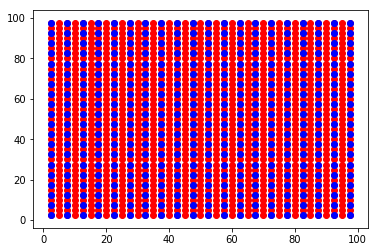

In [6]:
import matplotlib.pyplot as plt
#plt.scatter(data_ex1["longitude"],data_ex1["latitude"],c=data_ex1["y"])
#plt.scatter(new_data_ex1["longitude"],new_data_ex1["latitude"],c=new_data_ex1["y"])
plt.scatter(new_data_ex1["longitude"],new_data_ex1["latitude"],c="red")
plt.scatter(data_ex1["longitude"],data_ex1["latitude"],c="blue")